**SID**: 52095515

**PG Student**: Ioannis Keravnos

**Msc Thesis** - Sophisticated Adversarial Attacks on Facial Recogntion Systems and what the future holds.

# Building an FR model

## LIBRARY IMPORTS

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from mtcnn.mtcnn import MTCNN
import cv2
from tqdm.notebook import tqdm

## LOAD DATASET AND PREPROCESS

A few preprocessing steps are required to make the dataset ready for training

- Extrace faces
- Replace images with the extracted faces (This is common and much more efficient than including the whole image, since it can include many unimportant features)
- Rescale the images to a smaller size (also a matter of efficiency. It is handled by the face extraction function formulated below)
- Saving the train and test sets after preprocessing as numpy objects to enable easy reproduction of experiments in the future by just loading the numpy object.
- Clean dataset of any non-recognized faces since it will return None
- Encode class labels to one hot arrays for the classifier to use multiclass classification with catergorical entropy
- Cast to tf dataset to be able to perform the specified preprocessing
- Split the dataset into train and test arrays
- Creating batch organised datasets


### Face Extraction

In [2]:
# can detect multiple faces but for our tasks we assume just one face images only
def extract_faces_from_img(imagePath, required_size=(160, 160)):
    image = Image.open(imagePath)
    image = np.asarray(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = faceCascade.detectMultiScale(
                                        gray,
                                        scaleFactor=1.3,
                                        minNeighbors=3,
                                        minSize=(30, 30)
                                        )
    if len(faces) != 0:
        for (x, y, w, h) in faces:
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            roi_color = image[y:y + h, x:x + w]
        # resize pixels to the model size
        image = Image.fromarray(roi_color)
        image = image.resize(required_size)
        face_array = np.asarray(image)
    else:
        # if face is not detected we need to return None
        face_array = None
    return face_array

### Custom 6-person dataset for a classiffier

In [3]:
samples = {
            'n000810':'Ashley Olsen',
            'n002038':'David Hasselhoff',
            'n000419':'Amy Adams',
            'n000709':'Antonio Banderas',
            'n007619':'Russell Brand',
            'n002141':'Denzel Washington'
}

train_ds_path = r'C:\Users\Keravnos\Documents\VGG-Face2\data\vggface2_train.tar\train'

def prepare_dataset(samples, train_data_path):
    ds = []
    # list out dict keys
    key_list = list(samples.keys())
    #iterate over our 6 identity directories
    for k in tqdm(key_list,'Identities'):
        # use this as label
        label = samples[k]
        #directory path of images for each identity
        dir_path = os.path.join(train_data_path,k)
        print('Extracting images for', label)
        # iterate over image directory and extract faces
        for img in tqdm(os.listdir(dir_path),'Images'):
            # need the image path for the face extraction method
            img_path = os.path.join(dir_path,img)
            # create a face array variable where the extracted face is constructed by the function.
            face_array = extract_faces_from_img(img_path)
            # add both image and label in dataset
            ds.append((face_array,label))
    print('DATASET COMPILED!')
    return ds

In [4]:
ds = prepare_dataset(samples,train_ds_path)
ds = np.asarray(ds, dtype=object)
ds.shape

Identities:   0%|          | 0/6 [00:00<?, ?it/s]

Extracting images for Ashley Olsen


Images:   0%|          | 0/843 [00:00<?, ?it/s]

Extracting images for David Hasselhoff


Images:   0%|          | 0/542 [00:00<?, ?it/s]

Extracting images for Amy Adams


Images:   0%|          | 0/689 [00:00<?, ?it/s]

Extracting images for Antonio Banderas


Images:   0%|          | 0/451 [00:00<?, ?it/s]

Extracting images for Russell Brand


Images:   0%|          | 0/640 [00:00<?, ?it/s]

Extracting images for Denzel Washington


Images:   0%|          | 0/545 [00:00<?, ?it/s]

DATASET COMPILED!


(3710, 2)

### Clean all non recognised images from dataset.

Sometimes while extracting faces, there is a chance that a face will not be recognized, which will in turn yield a **None** object. This is something that we must clean from the dataset as it will create all sorts of errors on the way. Notice that while we search for **None** in images, we **must** still delete its corresponding label, hence the whole row for that specific data entry.

In [5]:
ds = [(image,label) for (image,label) in ds if image.__class__.__name__ != 'NoneType' ]
ds = np.asarray(ds, dtype=object)
ds.shape

(3068, 2)

### Create one hot arrays for the class labels

This is required since we are attempting to build a multi-class classifier. The following will encode string labels to numerical labels first using scikit-learn. Then we use tensorflows to_categorical utility function to convert the now numerical labelled data to one hot arrays.

In [25]:
from sklearn.preprocessing import LabelEncoder

images = [image for image,label in ds]
labels = [label for image,label in ds]

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = tf.keras.utils.to_categorical(encoded_Y)

### ******Optional (Save and load numpy files to cut through the previous steps)

Save the images and labels

In [26]:
np.save('images.npy', images)
np.save('labels.npy', dummy_y)

Or load them

In [27]:
dummy_y = np.load('labels.npy')
images = np.load('images.npy')

In [28]:
images.shape

(3068, 160, 160, 3)

### Splitting the dataset

It is required to split the dataset since we will be using a train and test set. To be exact we will be using the test set as a validation test, yet we will also use it to evaluate the model. This unconventional but it stems from the fact that classiffiers are built on much larger datasets, yet our images are scarse. This is one of the reasons we use transfer learning later on.

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, dummy_y, test_size=0.3, random_state=42)

### Preprocess datasets for Xception model and prepare batches

Here we do the following:

- Cast the split datasets to tensorflow Datasets to perform the rest of the preprocessing
- Shuffle the datasets
- Call the custom preprocess function to iteratively preprocess each data entry using the .map method of the Dataset class
- We finally prepare batches in sizes of 32 and prefetch it to increase speed

In [30]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))

In [31]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [32]:
def preprocess(image,label):
    image = tf.cast(image, tf.float32) / 255.0
    final_image = tf.keras.applications.xception.preprocess_input(image)
    return final_image,label

batch_size = 32
train_dataset = train_dataset.shuffle(len(train_dataset)*2)
train_dataset = train_dataset.map(preprocess).batch(batch_size).prefetch(1)

test_dataset = test_dataset.shuffle(len(test_dataset)*2)
test_dataset = test_dataset.map(preprocess).batch(batch_size).prefetch(1)


## BUILDING THE MODEL

Use Transfer Learning to build on top of an Xception model architecture for image classification.

### Use Xception architecture and weights

- We use Xception model architecture without its top layer.
- Add layers on top of the Xception model to form a classifier. The number of neurons must match the number of class labels. Use softmax since this is categorical classification 
- The Xception layers must be frozen so that the weights do not change in the first training run

In [33]:
from tensorflow import keras
from tensorflow.keras import layers

n_classes = len(list(samples.keys()))

base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(160, 160, 3),
    include_top=False
)  # Do not include the ImageNet classifier at the top.

x = keras.layers.GlobalAveragePooling2D()(base_model.output)
# x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
output = keras.layers.Dense(n_classes, activation='softmax')(x)
model = keras.Model(base_model.input, output)

# Freeze the base_model
for layer in base_model.layers:
    layer.trainable = False


model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 79, 79, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 79, 79, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback
import math

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, verbose=1, patience=4, min_lr=0.00001)

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# initial_learning_rate = 0.2
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,
#     decay_rate=0.9,
#     staircase=True)


# optimizer = SGD(learning_rate=0.2, momentum =0.9, decay=0.01)
# optimizer = SGD(learning_rate=0.02)
optimizer = Adam(learning_rate=0.2)

# recompile
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# train
history = model.fit(train_dataset,
                    batch_size=batch_size,
                    epochs=100,
                    validation_data=test_dataset,
                    verbose=1,
                    callbacks=[
                                reduce_lr,
                                ModelCheckpoint(filepath='model_ckp/model_at_ep{epoch}.h5'),
                                    ]
)


model.save('model_ckp/model_final.h5')

### Fine Tuning

In [ ]:
# unfreeze and retrain
for layer in base_model.layers:
    layer.trainable = True
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, verbose=1, patience=4, min_lr=0.00001)

model.load_weights('model_bkp/model_at_ep100.h5')

optimizer = Adam(1e-5)

# recompile
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# train
history = model.fit(train_dataset,
                    batch_size=batch_size,
                    epochs=150,
                    validation_data=test_dataset,
                    verbose=1,
                    callbacks=[
#                         reduce_lr,
                                ModelCheckpoint(filepath='model_FT_ckp/model_FT_at_ep{epoch}.h5'),
                                    ]
)
model.save('model_FT_ckp/model_FT_final.h5')

## EVALUATE THE MODEL

In [34]:
model.load_weights('model_bkp/model_FT_final.h5')

### Plot metrics

*Can be found in the Thesis document

In [ ]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')


plt.savefig('model_bkp/loss_acc_plot.png', dpi=100)
plt.show()

### Evaluate single predictions

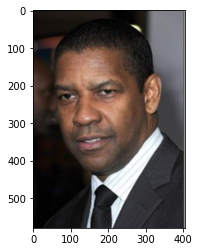

In [45]:
%matplotlib inline
# test_path = '0002_01.jpg'
# test_path = '0011_01.jpg'
# test_path = '0162_01.jpg'
test_path = '0003_01.jpg'

# read the image
test_img = Image.open(test_path)
#show image
plt.imshow(test_img)

Raw Image size: (580, 404, 3)
Extracted face image size: (160, 160, 3)


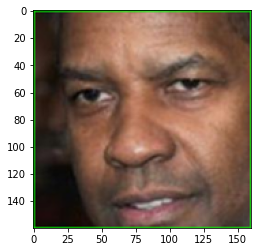

In [47]:
print('Raw Image size:',np.array(test_img).shape)
test_img = extract_faces_from_img(test_path)

plt.imshow(test_img)
print('Extracted face image size:',test_img.shape)

In [49]:
lbl = ''
img, lbl = preprocess(test_img,lbl)
img = np.expand_dims(img, axis=0)
img.shape

(1, 160, 160, 3)

In [57]:
# code inspired by keras_vvgface2.utils.decode_predictions
def decode_predictions(preds, top=6):
    results = []
    LABELS = encoder.classes_
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [[LABELS[i], pred[i]] for i in top_indices]
        result.sort(key=lambda x: x[1], reverse=True)
        results.append(result)
    return results


def show_predictions(predictions):
    print('Raw prediction:\n',decoded,'\n')
    for result in predictions:
        percentage = result[1]*100
        iclass = result[0]
        print("{}: {:.4f}%".format(iclass,percentage))
        
    
pred = model.predict(img, batch_size=None)
    
decoded = decode_predictions(pred)[0]

show_predictions(decoded)

Raw prediction:
 [['Denzel Washington', 1.0], ['Antonio Banderas', 1.0931963e-11], ['Russell Brand', 9.998914e-12], ['Ashley Olsen', 1.6354564e-12], ['David Hasselhoff', 1.2405327e-13], ['Amy Adams', 1.5462093e-15]] 

Denzel Washington: 100.0000%
Antonio Banderas: 0.0000%
Russell Brand: 0.0000%
Ashley Olsen: 0.0000%
David Hasselhoff: 0.0000%
Amy Adams: 0.0000%


# Adversarial Attacks

## Deepfool

In [ ]:
def Deepfool(image, label , classifier, num_classes=6):
    orginal_image = image
    perturbated_image = image
    predicted_label = label
    
    while label == predicted label:
        predicted_label = classifier.predict(image, batch_size=None)
        
        

In [ ]:

def is_probability(vector: np.ndarray) -> bool:
    """
    Check if an 1D-array is a probability vector.
    :param vector: An 1D-array.
    :return: True if it is a probability vector.
    """
    is_sum_1 = math.isclose(np.sum(vector), 1.0, rel_tol=1e-03)
    is_smaller_1 = np.amax(vector) <= 1.0
    is_larger_0 = np.amin(vector) >= 0.0
    
    
